In [1]:
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt




In [2]:
def load_fashion_mnist():
    """
    Loads Fashion MNIST dataset.
    
    Adapted from: https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
    """
    TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
    TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'    
    TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
    TEST_LABELS = 't10k-labels-idx1-ubyte.gz'

    with gzip.open(TRAIN_LABELS, 'rb') as tr_labels_file, gzip.open(TEST_LABELS, 'rb') as ts_labels_file:
        train_labels = np.frombuffer(tr_labels_file.read(), dtype=np.uint8, offset=8)
        test_labels = np.frombuffer(ts_labels_file.read(), dtype=np.uint8, offset=8)

    with gzip.open(TRAIN_IMAGES, 'rb') as tr_images_file, gzip.open(TEST_IMAGES, 'rb') as ts_images_file:
        train_images = np.frombuffer(tr_images_file.read(), dtype=np.uint8, offset=16).reshape(len(train_labels), 784)
        test_images = np.frombuffer(ts_images_file.read(), dtype=np.uint8, offset=16).reshape(len(test_labels), 784)

    return train_images, train_labels, test_images, test_labels


In [3]:
def pretty_print(image_example):
    """ Pretty prints a Fashion MNIST example.

    Parameters:
        image_example: a 1x784 numpy array corresponding to the features of
                       a single image.

    Returns:
        None.
    """
    print(np.array_str(image_example, precision=1, max_line_width=116))
    

In [2]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectPercentile, f_classif

In [5]:
"""Data Source"""
train_images, train_labels, test_images, test_labels = load_fashion_mnist()

In [20]:
"""Base line Knn - Knn without any data processing and hyperparameter tuning"""
knn_baseline = make_pipeline(KNeighborsClassifier())
knn_baseline.fit(train_images, train_labels)
print("The score of the baseline Knn model is: ", knn_baseline.score(test_images, test_labels))
baseknn_pred = knn_baseline.predict(test_images)
y_score_baseline = knn_baseline.fit(train_images, train_labels).predict_proba(test_images)

The score of the baseline Knn model is:  0.8554


In [23]:
"""Baseline dummy classifer - Stragegy: Always predict the most frequent class irrespective of the input"""
from sklearn.dummy import DummyClassifier
strategies=["most_frequent", "stratified"]

for strategy in strategies:
    dummy_clf = DummyClassifier(strategy = strategy)
    dummy_clf.fit(train_images, train_labels)
    print("The score of the baseline ",strategy," dummy model is: ",dummy_clf.score(test_images, test_labels))
#dummy_pred = dummy_clf.predict(test_images)
y_score_dummy = dummy_clf.fit(train_images, train_labels).predict_proba(test_images)

The score of the baseline  most_frequent  dummy model is:  0.1
The score of the baseline  stratified  dummy model is:  0.0984


In [20]:
"""
Primary Knn Implementation with pipeline and gridsearch for data-preprocessing and hyperparameter tuning
"""

knn_pipe = Pipeline([
    ('data_scaling', StandardScaler()),
    ('feature_selection', SelectPercentile(f_classif)),
    ('knn_classifier', KNeighborsClassifier(n_jobs = -1))
])

knn_paramgrid = {
    'data_scaling': [MinMaxScaler(), StandardScaler()],
    'feature_selection__percentile': [90, 80, 75, 70, 60], 
    'knn_classifier__n_neighbors': [3, 5, 7, 9],
    'knn_classifier__weights': ['uniform', 'distance']
}

knn_model = GridSearchCV(knn_pipe, knn_paramgrid, cv = 2, n_jobs = -1)
knn_model.fit(train_images, train_labels)
print("The score of the primary knn model is: ", knn_model.score(test_images, test_labels))
print("The model's best parameters are: ", knn_model.best_params_)



The score of the primary knn model is:  0.8595
The model's best parameters are:  {'data_scaling': StandardScaler(), 'feature_selection__percentile': 75, 'knn_classifier__n_neighbors': 5, 'knn_classifier__weights': 'distance'}


In [25]:
"""
Make a data frame using the results from GridSearchCV for model evaluation
"""

knn_results_dataframe = pd.DataFrame(knn_model.cv_results_)[['params', 
                                                       'mean_test_score', 
                                                       'std_test_score',
                                                       #'mean_train_score',
                                                       #'std_train_score',
                                                       'rank_test_score',
                                                       'mean_fit_time',
                                                       'std_fit_time',
                                                       'mean_score_time',
                                                       'std_score_time',
                                                        'param_feature_selection__percentile',
                                                        'param_knn_classifier__n_neighbors',
                                                      ]]

knn_results_dataframe['total_running_time'] = knn_results_dataframe['mean_fit_time'] + knn_results_dataframe['mean_score_time']
knn_results_dataframe.sort_values(['rank_test_score', 'total_running_time'], ascending = [True, True], inplace = True)
knn_results_dataframe.to_csv('knn_results.csv', index=False)

In [4]:

knn_data_frame = pd.read_csv('knn_results.csv')

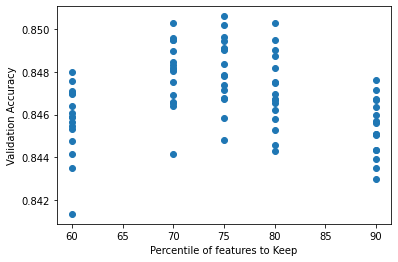

In [8]:
knn_data_frame = pd.read_csv('knn_results.csv')

plt.scatter(knn_data_frame['param_feature_selection__percentile'], knn_data_frame['mean_test_score'])
plt.xlabel('Percentile of features to Keep')
plt.ylabel('Validation Accuracy')
plt.savefig("keeppercentile.png")

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [14]:
y_pred = knn_model.predict(test_images)

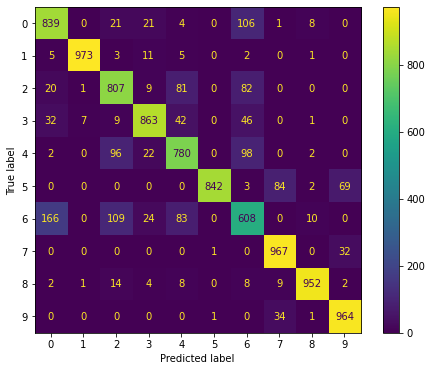

array([0.839, 0.973, 0.807, 0.863, 0.78 , 0.842, 0.608, 0.967, 0.952,
       0.964])

In [29]:
cm = confusion_matrix(test_labels, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=knn_model.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()
cm.diagonal()/cm.sum(axis=1)

In [26]:
knn_results_dataframe

,params,mean_test_score,std_test_score,rank_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_feature_selection__percentile,param_knn_classifier__n_neighbors,total_running_time
59,"{'data_scaling': StandardScaler(), 'feature_se...",0.850617,0.000783,1,2.058762,0.162027,53.964689,7.608175,75,5,56.023450
67,"{'data_scaling': StandardScaler(), 'feature_se...",0.850317,0.000983,2,2.843067,0.238930,53.066548,2.594413,70,5,55.909616
51,"{'data_scaling': StandardScaler(), 'feature_se...",0.850300,0.001100,3,2.663572,0.026554,58.916743,0.289111,80,5,61.580315
61,"{'data_scaling': StandardScaler(), 'feature_se...",0.850217,0.000017,4,2.406590,0.687048,52.628593,6.261057,75,7,55.035184
19,"{'data_scaling': MinMaxScaler(), 'feature_sele...",0.849650,0.000017,5,2.183656,0.009619,58.487916,0.098537,75,5,60.671572
...,...,...,...,...,...,...,...,...,...,...,...
4,"{'data_scaling': MinMaxScaler(), 'feature_sele...",0.843900,0.000033,76,2.537976,0.726840,72.032716,1.885098,90,7,74.570691
33,"{'data_scaling': MinMaxScaler(), 'feature_sele...",0.843500,0.000367,77,2.056741,0.066921,47.230518,0.135037,60,3,49.287259
6,"{'data_scaling': MinMaxScaler(), 'feature_sele...",0.843500,0.000333,77,1.845096,0.062521,75.698921,0.619659,90,9,77.544017
0,"{'data_scaling': MinMaxScaler(), 'feature_sele...",0.842950,0.000750,79,1.220341,0.001147,76.817434,0.734561,90,3,78.037775


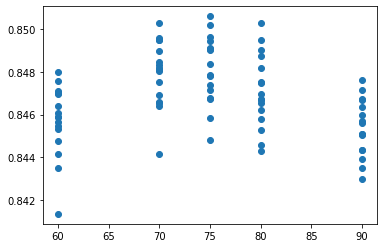

In [31]:
plt.scatter(knn_results_dataframe['param_feature_selection__percentile'], knn_results_dataframe['mean_test_score'])
plt.savefig("percentile.png")

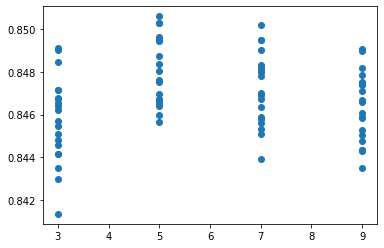

In [27]:
plt.scatter(knn_results_dataframe['param_knn_classifier__n_neighbors'], knn_results_dataframe['mean_test_score'])

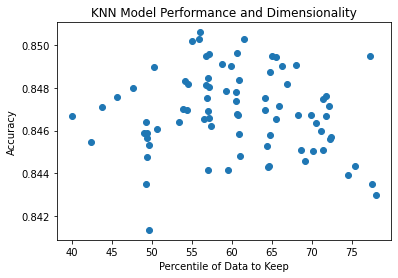

In [71]:
plt.scatter(knn_results_dataframe['total_running_time'], knn_results_dataframe['mean_test_score'])
plt.xlabel('Percentile of Data to Keep')
plt.ylabel('Accuracy')
plt.title('KNN Model Performance and Dimensionality')
plt.savefig("Percentile.png")
plt.show()


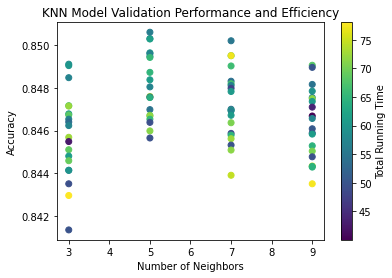

In [67]:

# Extract the relevant columns from the dataframe
accuracy = knn_results_dataframe['mean_test_score']
num_neighbors = knn_results_dataframe['param_knn_classifier__n_neighbors']
total_time = knn_results_dataframe['total_running_time']

# Create a scatter plot
plt.scatter(num_neighbors, accuracy, c=total_time, cmap='viridis')
plt.colorbar(label='Total Running Time')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Model Validation Performance and Efficiency')
plt.savefig('knn_performance.png', dpi=300, bbox_inches='tight')
plt.show()


In [10]:
distance_method = [1, 2]
for method in distance_method:
    knn_pipe_final = Pipeline([
        ('data_scaling', StandardScaler()),
        ('feature_selection', SelectPercentile(f_classif, percentile = 75)),
        ('knn_classifier', KNeighborsClassifier(n_neighbors = 5, weights = 'distance', n_jobs = -1, p = method))
    ])
    knn_pipe_final.fit(train_images, train_labels)
    print("The score of the primary knn model is: ", knn_pipe_final.score(test_images, test_labels))

#We have found that p = 1 has a better accuracy



The score of the primary knn model is:  0.8634
The score of the primary knn model is:  0.8595


In [27]:
#Same model with p = 1
knn_pipe_final = Pipeline([
        ('data_scaling', StandardScaler()),
        ('feature_selection', SelectPercentile(f_classif, percentile = 75)),
        ('knn_classifier', KNeighborsClassifier(n_neighbors = 5, weights = 'distance', n_jobs = -1, p = 1))
    ])
knn_pipe_final.fit(train_images, train_labels)
#y_score = knn_pipe_final.fit(train_images, train_labels).predict_proba(test_images)
y_pred = knn_pipe_final.predict(test_images)
#print("The score of the primary knn model is: ", knn_pipe_final.score(test_images, test_labels))

In [11]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer().fit(train_labels)
y_onehot_test = label_binarizer.transform(test_labels)
y_onehot_test.shape  # (n_samples, n_classes)
#y_onehot_test

(10000, 10)

6

NameError: name 'np' is not defined

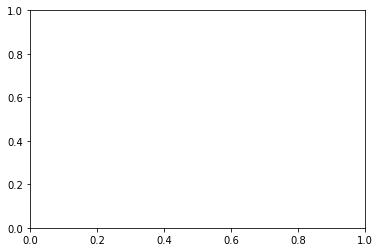

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
class_array = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fig, ax = plt.subplots()

for classes in class_array:
    class_of_interest = classes
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    class_id
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{class_of_interest} vs the rest",
        #color="darkorange",
        ax = ax
    )
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.savefig('roc_curve_finalised.png', dpi = 400)
plt.show()


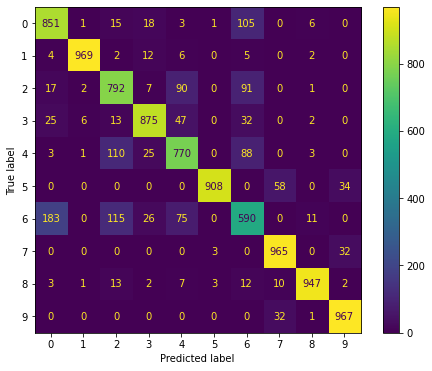

In [14]:
y_pred = knn_pipe_final.predict(test_images)
cm_final = confusion_matrix(test_labels, y_pred)
disp_final = ConfusionMatrixDisplay(confusion_matrix=cm_final,
                               display_labels=knn_pipe_final.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp_final.plot(ax=ax)
plt.savefig('confusion_matrix_improved.png', dpi=300)
plt.show()


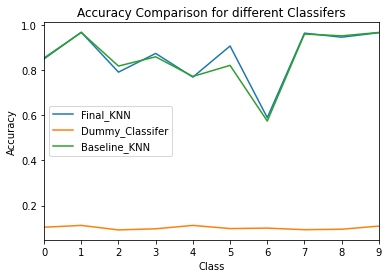

In [68]:
Knn_array = cm_final.diagonal()/cm_final.sum(axis=1)
cm_dummy = confusion_matrix(test_labels, dummy_pred)
cm_baseknn = confusion_matrix(test_labels, baseknn_pred)
dummy_array = cm_dummy.diagonal()/cm_dummy.sum(axis=1)
baseknn_array = cm_baseknn.diagonal()/cm_baseknn.sum(axis=1)


plt.plot(Knn_array, label="Final_KNN")
plt.plot(dummy_array, label="Dummy_Classifer")
plt.plot(baseknn_array, label="Baseline_KNN")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison for different Classifers")
plt.legend()
plt.xlim(0, 9)
plt.savefig("accuracy_comparison.png")
plt.show()



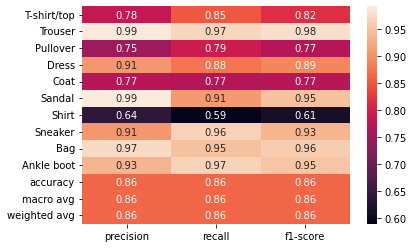

In [28]:
from sklearn.metrics import classification_report
import seaborn as sns
target_name = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
clf_report = classification_report(test_labels,
                                   y_pred,
                                   target_names=target_name,
                                   output_dict=True)
sns_plot = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
sns_plot.figure.savefig('heatmap_finalised.png', dpi=300, bbox_inches='tight')

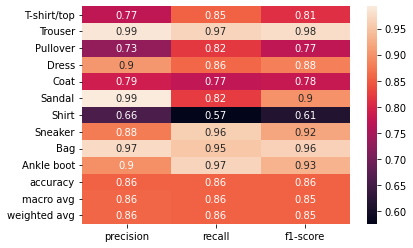

In [29]:
from sklearn.metrics import classification_report
import seaborn as sns
target_name = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
clf_report = classification_report(test_labels,
                                   baseknn_pred,
                                   target_names=target_name,
                                   output_dict=True)
sns_plot = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
sns_plot.figure.savefig('heatmap_baselineknn.png', dpi=300, bbox_inches='tight')

In [25]:
sns_plot.figure.savefig('heatmap.png', dpi=300, bbox_inches='tight')

In [47]:
neigh = KNeighborsClassifier(n_neighbors=5, weights = 'distance', p = 1, n_jobs = -1)
neigh.fit(train_images, train_labels)
class6_indices = np.where(test_labels == 6)[0]

# Initialize an empty list to store the indices of the nearest neighbors for each instance of class 6
class6_neighbors = []

# Loop over the indices of class 6 instances
for index in class6_indices:
    # Get the 5 nearest neighbors for the current instance
    distances, indices = neigh.kneighbors(test_images[index].reshape(1, -1), n_neighbors=5)
    # Append the indices of the nearest neighbors to the list
    class6_neighbors.append(train_labels[indices])

In [48]:
np.shape(class6_neighbors)
#class6_neighbors_labels = []
#for index in 

(1000, 1, 5)

In [51]:
print(class6_neighbors[0:40])

[array([[6, 0, 6, 6, 6]], dtype=uint8), array([[6, 6, 6, 6, 6]], dtype=uint8), array([[6, 6, 6, 6, 4]], dtype=uint8), array([[0, 6, 0, 6, 0]], dtype=uint8), array([[4, 4, 2, 6, 2]], dtype=uint8), array([[6, 6, 6, 6, 0]], dtype=uint8), array([[2, 2, 6, 2, 6]], dtype=uint8), array([[6, 6, 6, 6, 6]], dtype=uint8), array([[6, 6, 6, 6, 6]], dtype=uint8), array([[6, 6, 2, 2, 6]], dtype=uint8), array([[6, 6, 6, 6, 6]], dtype=uint8), array([[6, 6, 6, 6, 6]], dtype=uint8), array([[3, 3, 3, 3, 3]], dtype=uint8), array([[6, 6, 6, 6, 8]], dtype=uint8), array([[6, 6, 6, 2, 6]], dtype=uint8), array([[6, 6, 6, 6, 6]], dtype=uint8), array([[6, 6, 2, 2, 6]], dtype=uint8), array([[6, 6, 6, 6, 6]], dtype=uint8), array([[2, 6, 6, 6, 2]], dtype=uint8), array([[2, 2, 2, 2, 2]], dtype=uint8), array([[6, 6, 6, 2, 6]], dtype=uint8), array([[6, 4, 6, 0, 4]], dtype=uint8), array([[6, 6, 6, 6, 6]], dtype=uint8), array([[6, 6, 0, 6, 0]], dtype=uint8), array([[6, 6, 6, 6, 4]], dtype=uint8), array([[6, 6, 6, 6, 4]],

In [53]:
arr = np.arange(1000)

# Randomly select 50 elements from the array
sample = np.random.choice(arr, size=100, replace=False)
for i in sample: 
    print(class6_neighbors[i])

[[0 0 0 0 0]]
[[6 6 6 6 6]]
[[6 6 6 6 4]]
[[6 6 6 6 6]]
[[3 4 3 3 3]]
[[6 2 4 2 6]]
[[6 0 6 6 0]]
[[0 0 0 0 0]]
[[6 0 6 0 0]]
[[0 0 6 6 0]]
[[6 2 2 2 4]]
[[0 6 0 0 6]]
[[4 4 2 6 4]]
[[8 4 4 4 4]]
[[6 6 6 6 6]]
[[0 6 0 0 0]]
[[2 4 2 2 4]]
[[2 6 2 6 6]]
[[6 6 6 6 6]]
[[6 6 3 0 6]]
[[2 4 2 4 4]]
[[6 3 3 0 0]]
[[0 6 0 6 6]]
[[6 6 6 6 6]]
[[6 6 6 6 6]]
[[6 6 6 6 6]]
[[0 2 6 2 6]]
[[6 6 6 6 6]]
[[6 0 0 0 6]]
[[6 6 6 6 6]]
[[2 4 4 4 4]]
[[0 0 0 6 6]]
[[0 6 8 6 8]]
[[0 0 0 0 0]]
[[6 6 6 6 6]]
[[6 6 0 0 2]]
[[6 0 6 6 6]]
[[6 6 6 6 2]]
[[0 6 6 6 0]]
[[6 6 6 6 4]]
[[3 6 6 6 6]]
[[6 6 6 6 2]]
[[6 6 6 6 6]]
[[3 0 6 6 2]]
[[6 8 8 8 8]]
[[0 0 6 6 6]]
[[6 6 2 6 2]]
[[6 6 6 6 6]]
[[2 6 4 4 4]]
[[6 0 0 6 0]]
[[0 0 0 0 0]]
[[6 6 6 6 6]]
[[6 6 4 6 2]]
[[6 6 6 6 6]]
[[6 6 6 6 6]]
[[6 6 6 6 6]]
[[6 6 6 6 6]]
[[6 2 6 6 2]]
[[6 6 6 6 6]]
[[0 0 6 0 0]]
[[0 0 2 2 0]]
[[6 6 6 6 4]]
[[6 4 6 4 6]]
[[6 6 6 3 6]]
[[3 0 0 0 0]]
[[2 6 2 2 2]]
[[6 6 6 6 6]]
[[6 6 4 6 6]]
[[6 0 0 0 0]]
[[2 6 6 6 4]]
[[6 2 2 6 2]]
[[6 6 

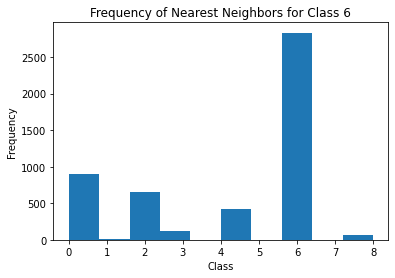

In [69]:
# Flatten the nested array of indices
flattened_indices = np.array(class6_neighbors).flatten()

plt.hist(flattened_indices)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Frequency of Nearest Neighbors for Class 6")
plt.savefig("Histogram.png")
plt.show() 



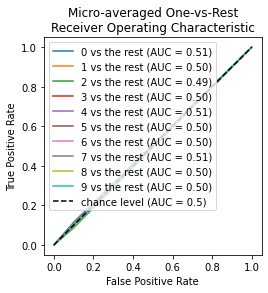

In [26]:
class_array = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fig, ax = plt.subplots()

for classes in class_array:
    class_of_interest = classes
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    class_id
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score_dummy[:, class_id],
        name=f"{class_of_interest} vs the rest",
        #color="darkorange",
        ax = ax
    )
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.savefig('roc_curve_dummy.png', dpi = 300)
plt.show()
